#Getting started: Setup phase
To get started with this exercises notebook, first make the necessary imports.

In [ ]:
!pip install -q langchain langchain-classic langchain-community langchain-core langchain-openai wikipedia

from google.colab import userdata
from transformers import pipeline
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_community.document_loaders import CSVLoader
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain_community.document_loaders import WikipediaLoader
from IPython.display import Markdown
import ast
import os
import pprint
import getpass

Then, assign the API keys to be able to use Google Serper and OpenAI.

When working with sensitive information like API keys or passwords in Google Colab, it's crucial to handle data securely. As you learnt in the tutorial session, two common approaches for this are using **Colab's Secrets Manager**, which stores and retrieves secrets without exposing them in the notebook, and `getpass`, a Python function that securely prompts users to input secrets during runtime without showing them. Both methods help ensure your sensitive data remains protected.

In [ ]:
#When using Colab Secret Manager
os.environ["SERPER_API_KEY"] = userdata.get('SERPER_API_KEY')
#When using getpass
#os.environ['SERPER_API_KEY'] = getpass.getpass()

#When using Colab Secret Manager
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
#When using getpass
#os.environ['OPENAI_API_KEY'] = getpass.getpass()

Lastly, define the search model and the llm to use throughout.

In [ ]:
search = GoogleSerperAPIWrapper()

llm = ChatOpenAI(model="gpt-5-mini")

You now have everything set up to carry out the exercises in this notbook.

#Exercise 1: Load and summarize a Wikipedia article

This exercise introduces a **simple multi-step pipeline** built with LangChain.

You will:
1. Load an article from Wikipedia using a LangChain loader
2. Convert the content into structured documents
3. Use a prompt template and an LLM to extract representative keywords from the article

This exercise demonstrates how multiple components—data loading, prompt templates, and model calls—can be composed into a reusable workflow.
A visualization of the solution is depicted below.


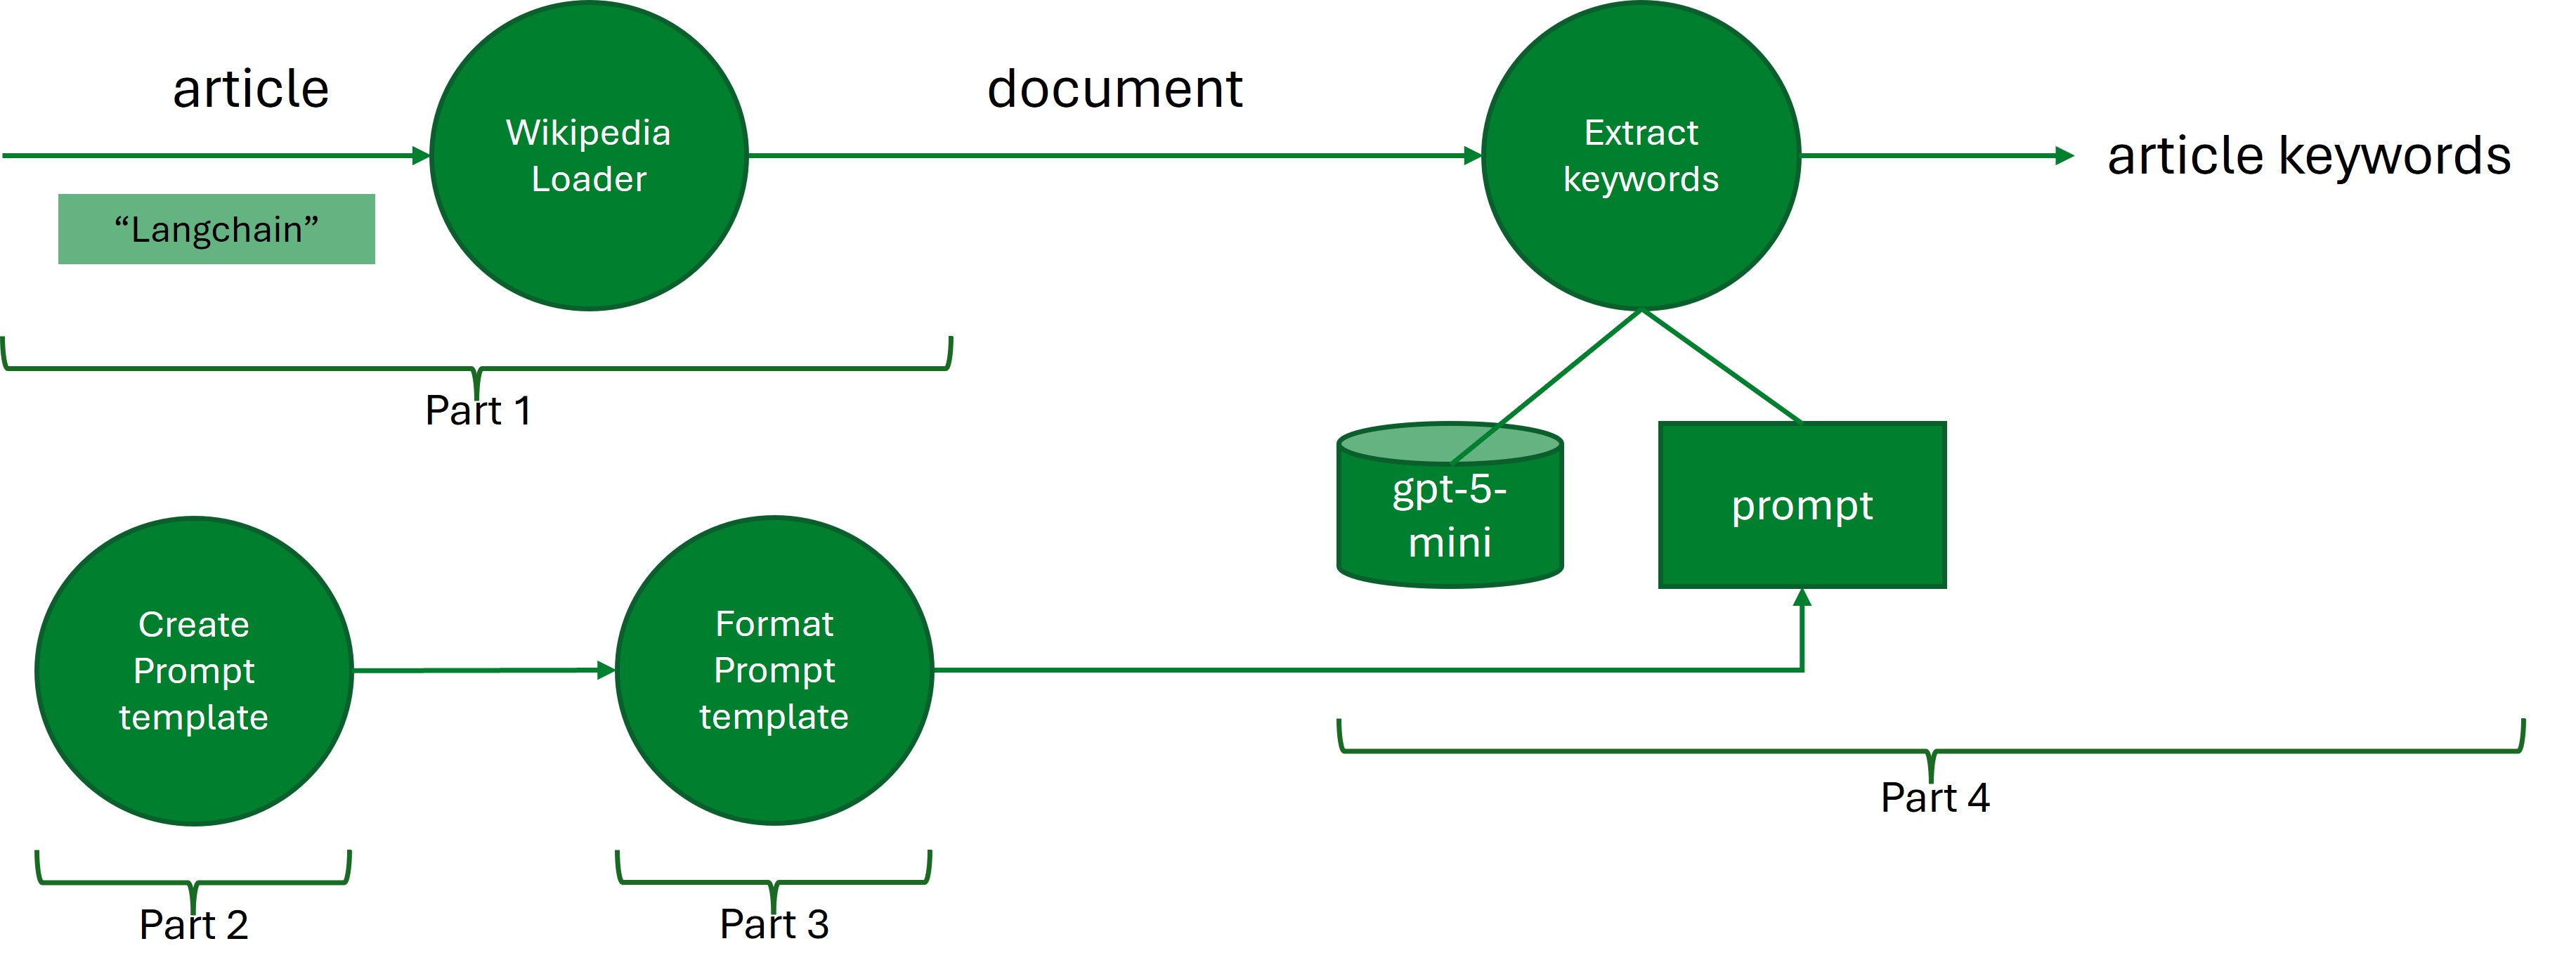

### Part 1. Load the Wikipedia article

Use the Langchain Wikipedia loader that you have seen in the tutorial to load an article about Langchain.

In [ ]:
# Load the article
## YOUR CODE (START)
loader = WikipediaLoader("Langchain")
document = loader.load()
wikipedia_page = document[0].page_content
## YOUR CODE (END)

### Part 2. Create a prompt template

Create a prompt template that asks to extract 5 representative keywords from the contents of a Wikipedia article represented by the variable `article`.

In [ ]:
# Create the prompt template
## YOUR CODE (START)
keywords_prompt_template = PromptTemplate.from_template(
    "Extract 5 representative keywords from the contents of this article: {article}."
)
## YOUR CODE (END)

### Part 3. Format the prompt template

Format the prompt template by assigning to the variable `article` the content of the Wikipedia page you loaded in the first step.

In [ ]:
# Format the template
## YOUR CODE (START)
keywords_prompt = keywords_prompt_template.format(article=wikipedia_page)
## YOUR CODE (END)

### Part 4. Generate the keywords and display the result

Invoke the `llm` with the formatted prompt to obtain the keywords. Then, display the result using Markdown.

In [ ]:
#Invoke the llm with the formatted template and display the result
## YOUR CODE (START)
response = llm.invoke(keywords_prompt)
display(Markdown(response.content))
## YOUR CODE (END)

# Exercise 2: Trading insights from a fixed list of companies
In this exercise, you will get actionable insights for investment based on recent trading results of the companies you are investing in.

(1) You will first retrieve a list of ticker symbols for companies, then

(2) retrieve the trading results for these companies from Google, then

(3) define a function using the OpenAI API to generate a report of the results, and

(4) define a function to generate actionable insights based on the report, and finally

(5) combine the two functions into a sequential chain.

To accomplish this, you can expand the code provided in the following.

A visualization of the solution to this exercise is depicted below.

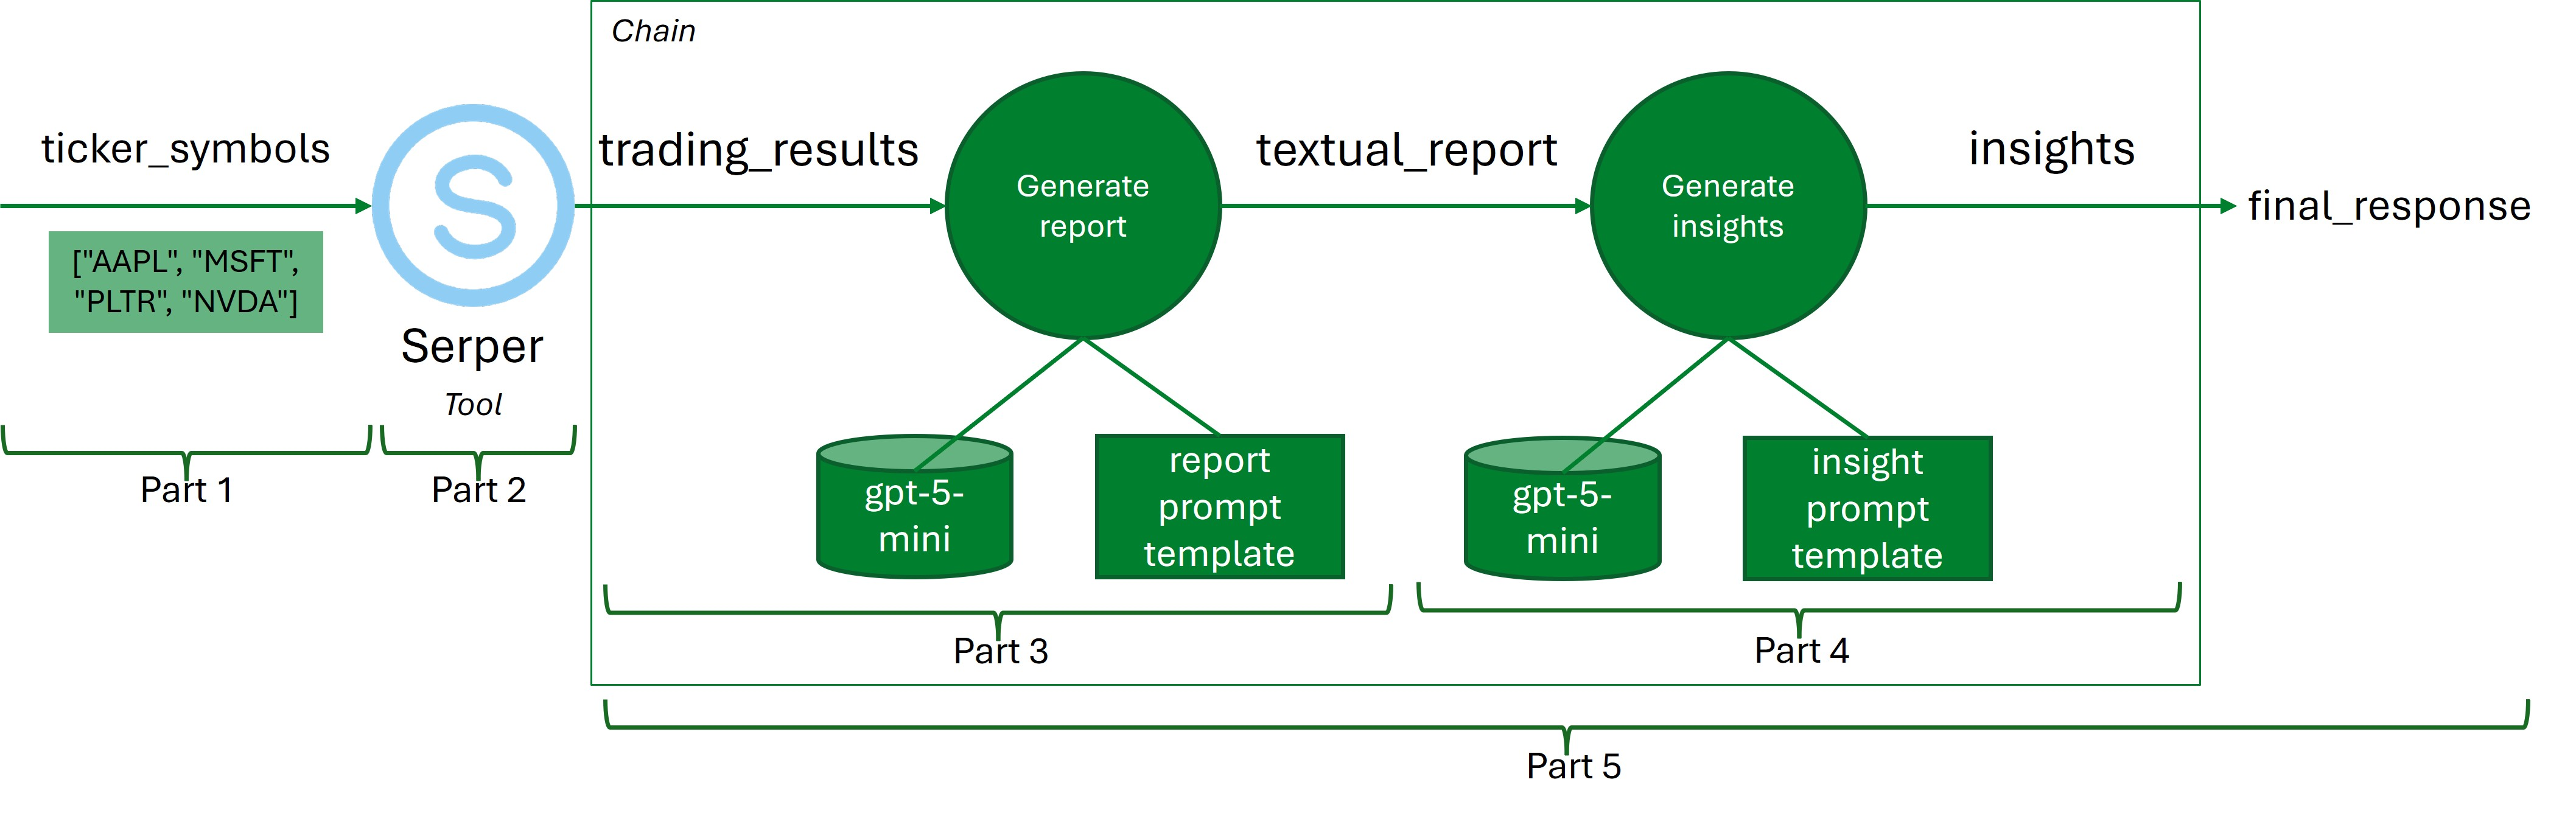

### Part 1. Load the ticker symbols of the companies you invest in
In the first part, you load a list of ticker symbols of companies in the stock market.

Here, we assume that the list is predefined with the symbols of Apple, Microsoft, Palantir, and NVIDIA.

In [ ]:
ticker_symbols = ["AAPL", "MSFT", "PLTR", "NVDA"]

### Part 2. Retrieve recent trading results for the ticker symbols

Use the `GoogleSerperAPIWrapper` (which you assigned to `search` in the Setup phase) to run a query for each ticker symbol in `ticker_symbols`.

**Hint:** To do so, iterate over the individual ticker symbols in the list using the "`for ... in ...:`" structure. In each iteration, it is sufficient to just call the method `run` of the GoogleSerperAPIWrapper (identified by `search`) passing the ticker symbol as parameter: the query will return the recent trading results for the respective company. For example, if you search `AAPL`, the result will look like `233.28 -1.12 (0.48%)`.

The result of running the queries (one per ticker symbol) should be a concatenation of the individual results in a single string `trading_results`. The structure of this string should be as follows: a ticker symbol, followed by the respective trading result, and then a semicolon (";"), followed by the same structure for the remaining symbols. An example for the result is as follows:

`AAPL 233.28 -1.12 (0.48%);MSFT 415.67 -1.52 (0.36%);PLTR 217.76 -0.70 (0.32%);NVDA 131.76 -1.47 (1.10%);`

In [ ]:
# Initialize an empty string where to append the results
trading_results = ""

# Iterate over the ticker symbols to run the query and append the results as specified
## YOUR CODE (START)
for ticker_symbol in ticker_symbols:
    result = search.run(ticker_symbol)
    trading_results = trading_results + ticker_symbol + " " + result + "; "
## YOUR CODE (END)

In [ ]:
# Display the trading results in Markdown
display(Markdown(trading_results))

### Part 3. Create a prompt template to get a report in natural language for the trading results

Use `PromptTemplate` to define a prompt template called `report_prompt_template`.

The prompt template should take as input variable the string `trading_results` that was generated in the previous step.

The template should ask the llm to provide a report for the trading results that are in the input variable.

The template should specify that the report must only talk about variations in percent, not in dollars.

The template should also specify that the report must have a maximum length of 200 words.

In [ ]:
# Define the prompt template
## YOUR CODE (START)
report_prompt_template = PromptTemplate(
    input_variable =["trading_results"],
    template = ("Based on the a list with ticker symbols {trading_results} create a report with a maximum length of 200 words. The report must only talk about variations in percent, not in dollars.")
)
## YOUR CODE (END)

### Part 4. Create a prompt template to generate actionable insights for investors based on a report

Use PromptTemplate to define a prompt template `insight_prompt_template`.

The prompt template should take as input variable `textual_report` (which is going to be the output of the previous prompt template).

The template should ask the llm to provide actionable insights for investors based on the report in the input variable.

The template should also specify that the insights for each company mentioned in the report must have a maximum length, e.g., 50 words.

In [ ]:
# Define the prompt template
## YOUR CODE (START)
insight_prompt_template = PromptTemplate(
    input_variables=["textual_report"],
    template=(
        "Based on the following trading report about selected companies, for each mentioned company extract 50-words actionable insights for investors: {textual_report}."
    )
)
## YOUR CODE (END)

### Part 5. Create a sequential chain where the trading results from Part 2 are used as input and the daily report and actionable insights are printed

Use `RunnablePassthrough` combined with the `assign()` method to create a structured, multi-stage chain called `complete_chain`, with:

* `textual_report` as the output variable for the first prompt processing,
* `insights` as the output of the second prompt processing
* `llm` (which was defined in the Setup phase) as the model processing the prompts.

In [ ]:
# Combine the chains
## YOUR CODE (START)
complete_chain = (
    RunnablePassthrough()
    .assign(textual_report=report_prompt_template | llm | StrOutputParser())
    .assign(insights=insight_prompt_template | llm | StrOutputParser())
)
## YOUR CODE (END)

Invoke the `complete_chain`, passing `trading_results` from Step 2 as the input variable for `trading_results`.

The result of the complete chain invocation should be assigned to a variable called `final_response`.

In [ ]:
# Run the complete chain
## YOUR CODE (START)
final_response = complete_chain.invoke({"trading_results": trading_results})
## YOUR CODE (END)

Lastly, display the results of the chain invocation to read the report and insights:

In [ ]:
# Display the result of the chain
display(Markdown(final_response["textual_report"]))
display(Markdown(final_response["insights"]))

# Exercise 3: Testing with different lists of companies

In exercise 2, you used a list of given ticker symbols, set in Part 1 with `ticker_symbols = ["AAPL", "MSFT", "PLTR", "NVDA"]`.

Test the code with different ticker symbols. For this, modify the list `ticker_symbols` by replacing `["AAPL", "MSFT", "PLTR", "NVDA"]` with other ticker symbols.

Re-execute Part 2 and Part 5 from exercise 2, this time using a new list of four ticker symbols of your choice. There is no need to re-execute Part 3 and Part 4 as the prompt templates and chains can be reused.

**Hint:** You can refer to https://stockanalysis.com/stocks/ to get inspiration and find new symbols. You can modify the list at the beginning of the exercise, without having to write new code here.

A visualization of the solution to this exercise is depicted below.

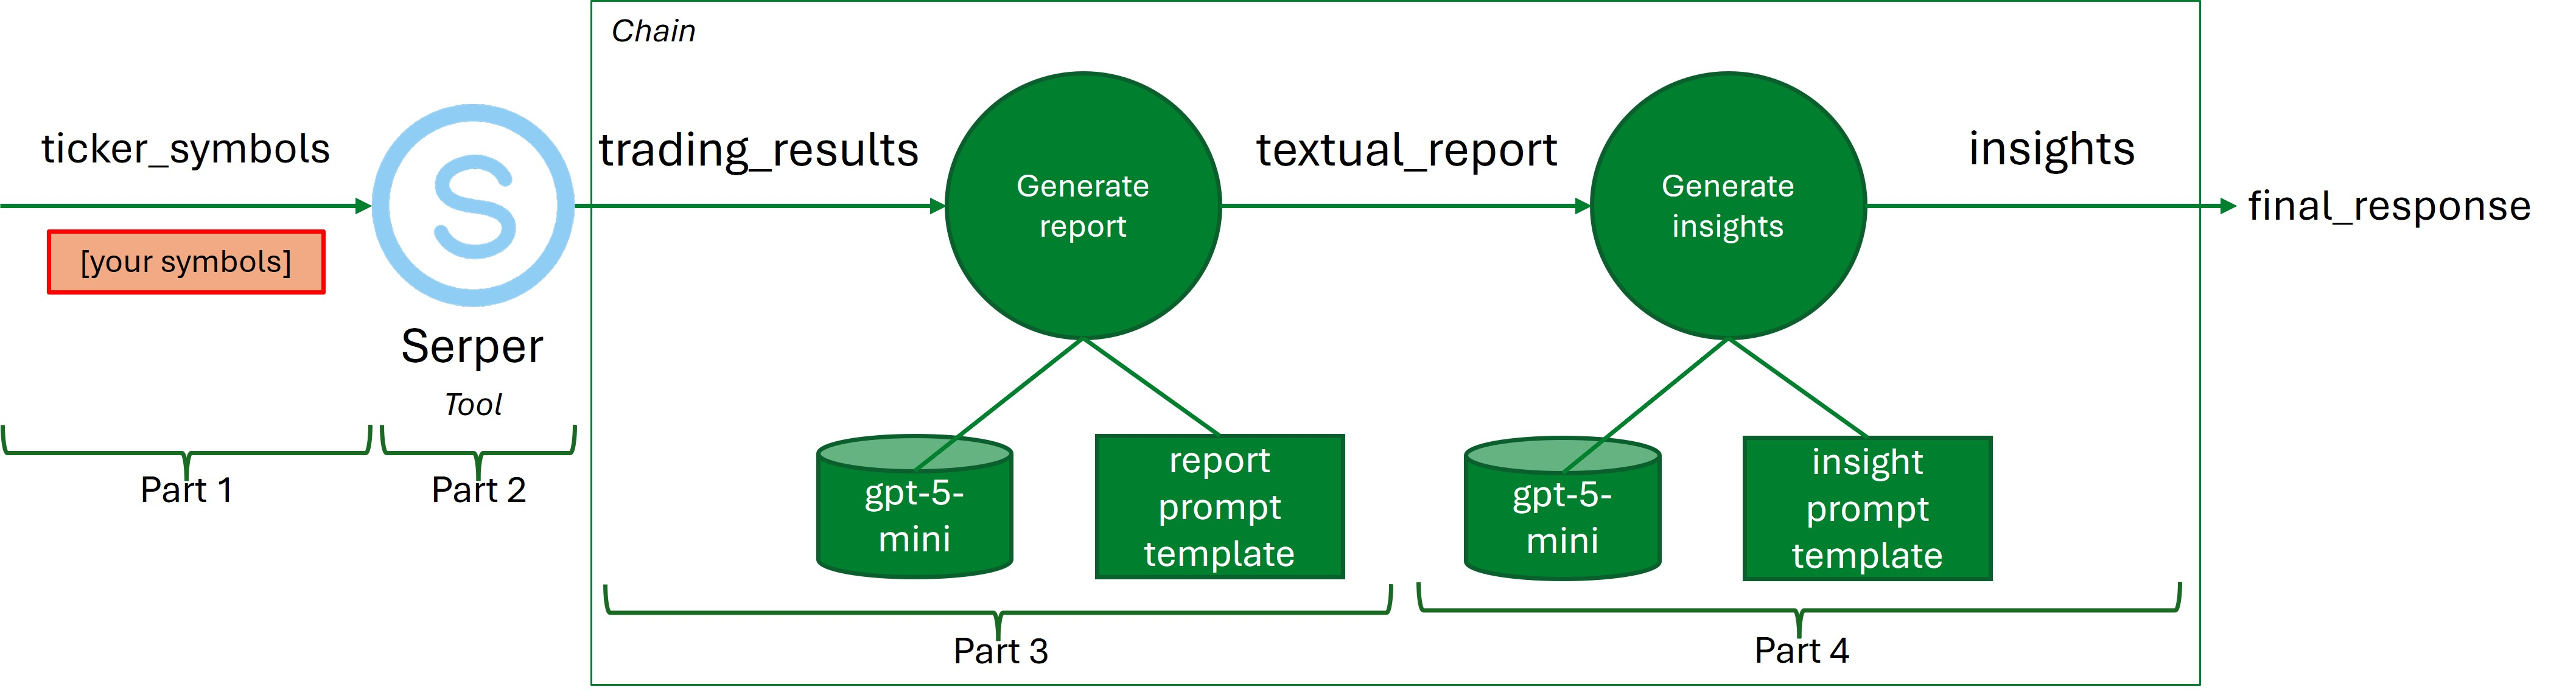

# Exercise 4: Testing with different models and prompts

In the beginning, you defined the LLM in the Setup phase with `llm = ChatOpenAI(model="gpt-5-mini")`, and used this LLM throughout all subsequent steps. Moreover, in exercise 2 you defined the prompts to get the trading results and the insights.

In this exercise, you will iterate defining and executing the chain with different models and prompts. For this, you can just replace `gpt-5-mini` with another OpenAI model of your choice, such as `gpt-5.1-mini`, `gpt-5.1-nano`, `gpt-5.1`. You should also revise the prompts based on the results you obtained in the previous executions, for example to obtain a more focused report and more detailed insights.

Then re-execute Parts 3--5 of your solution to exercise 2, evaluate the results, and try again using a different model and prompts.

**Hint:** You can refer to https://platform.openai.com/docs/models for a list of available models. You can modify the code cells in exercise 2, without having to write new code here.

A visualization of the solution to this exercise is depicted below.

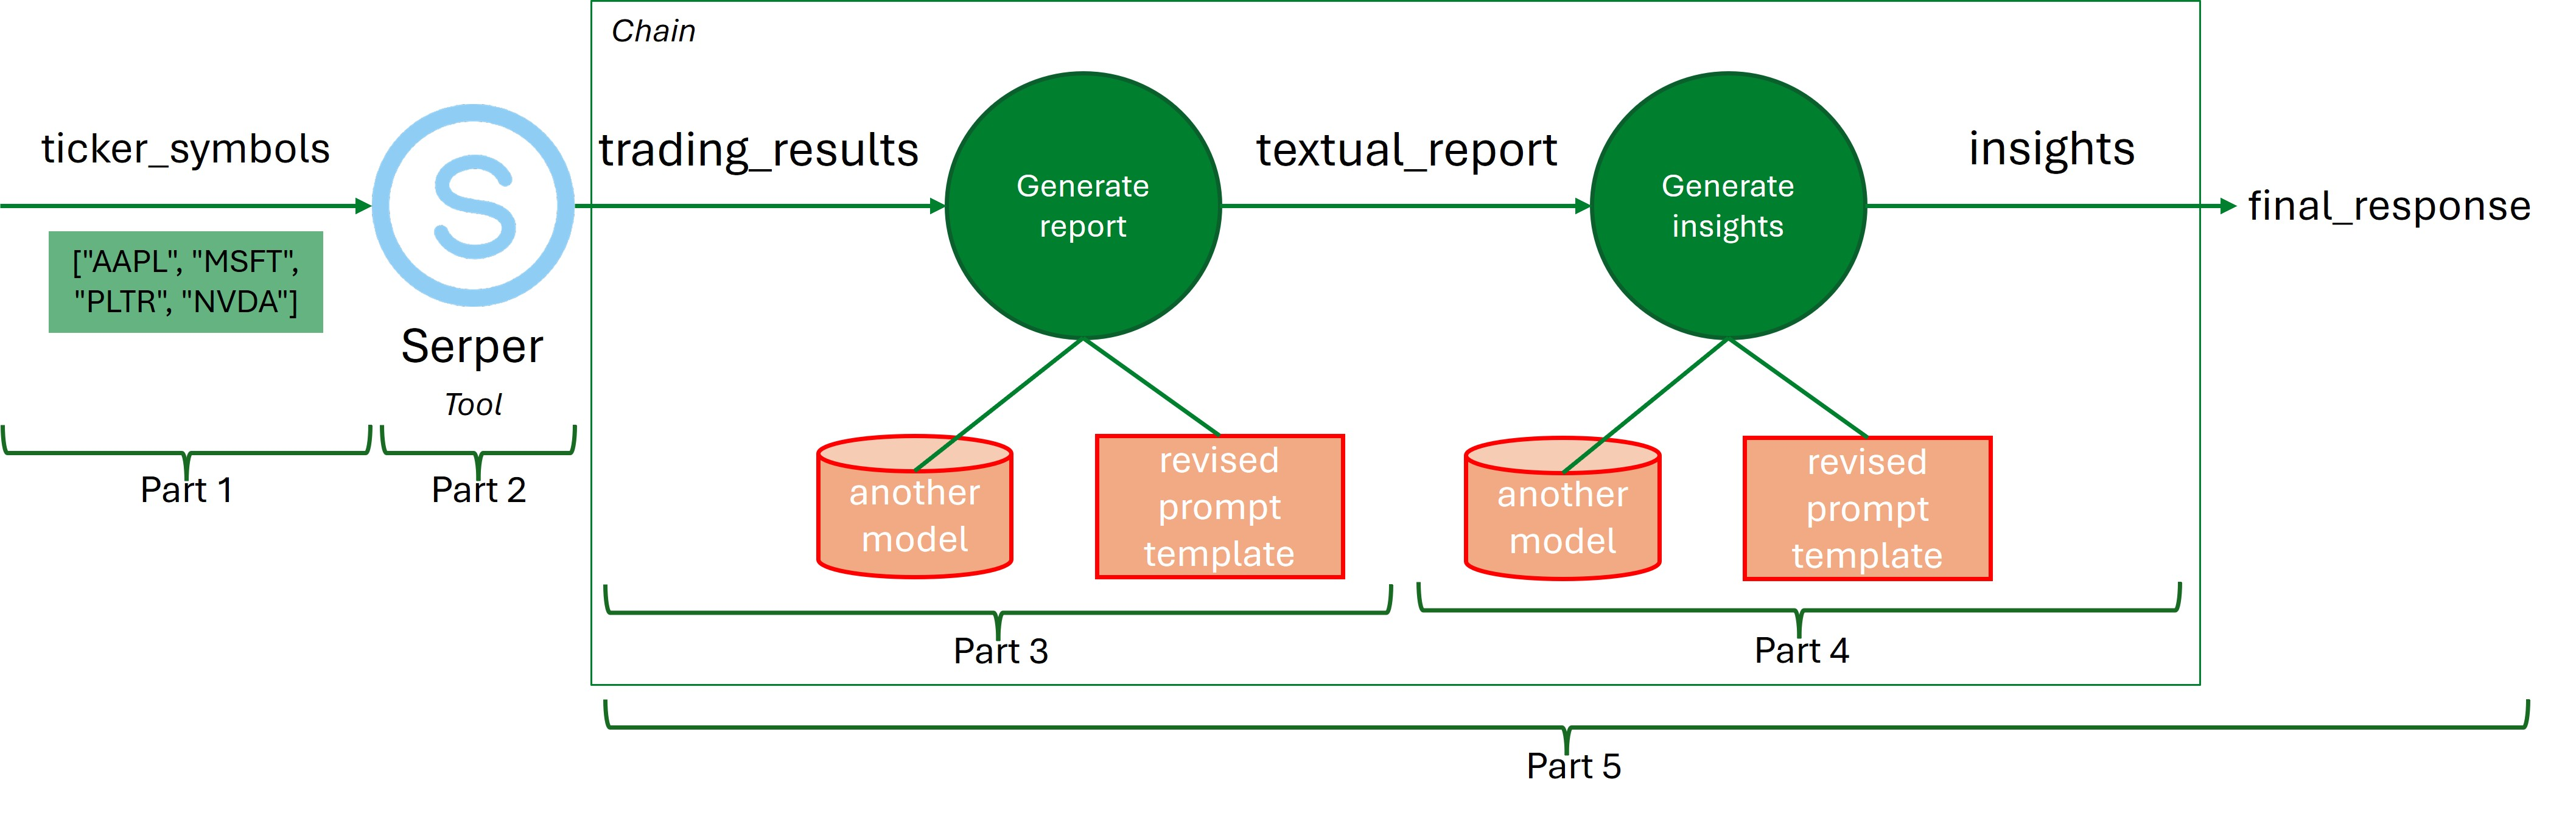

# Exercise 5: Trading insights from a CSV file with companies

In the previous exercises, you used a fixed lists of ticker symbols, which is not flexible.

In this exercise, you will extend the solution of exercise 2, so that the list of ticker symbols is loaded from a CSV file `ticker_symbols.csv`.

To accomplish this, you can first expand the code provided below. More specifically, expand the code in Part 1; for Parts 2--5, you can then re-execute the code cells defined above (exercise 2), since the prompt templates and the sequential chain are reusable.

A visualization of the solution to this exercise is depicted below.

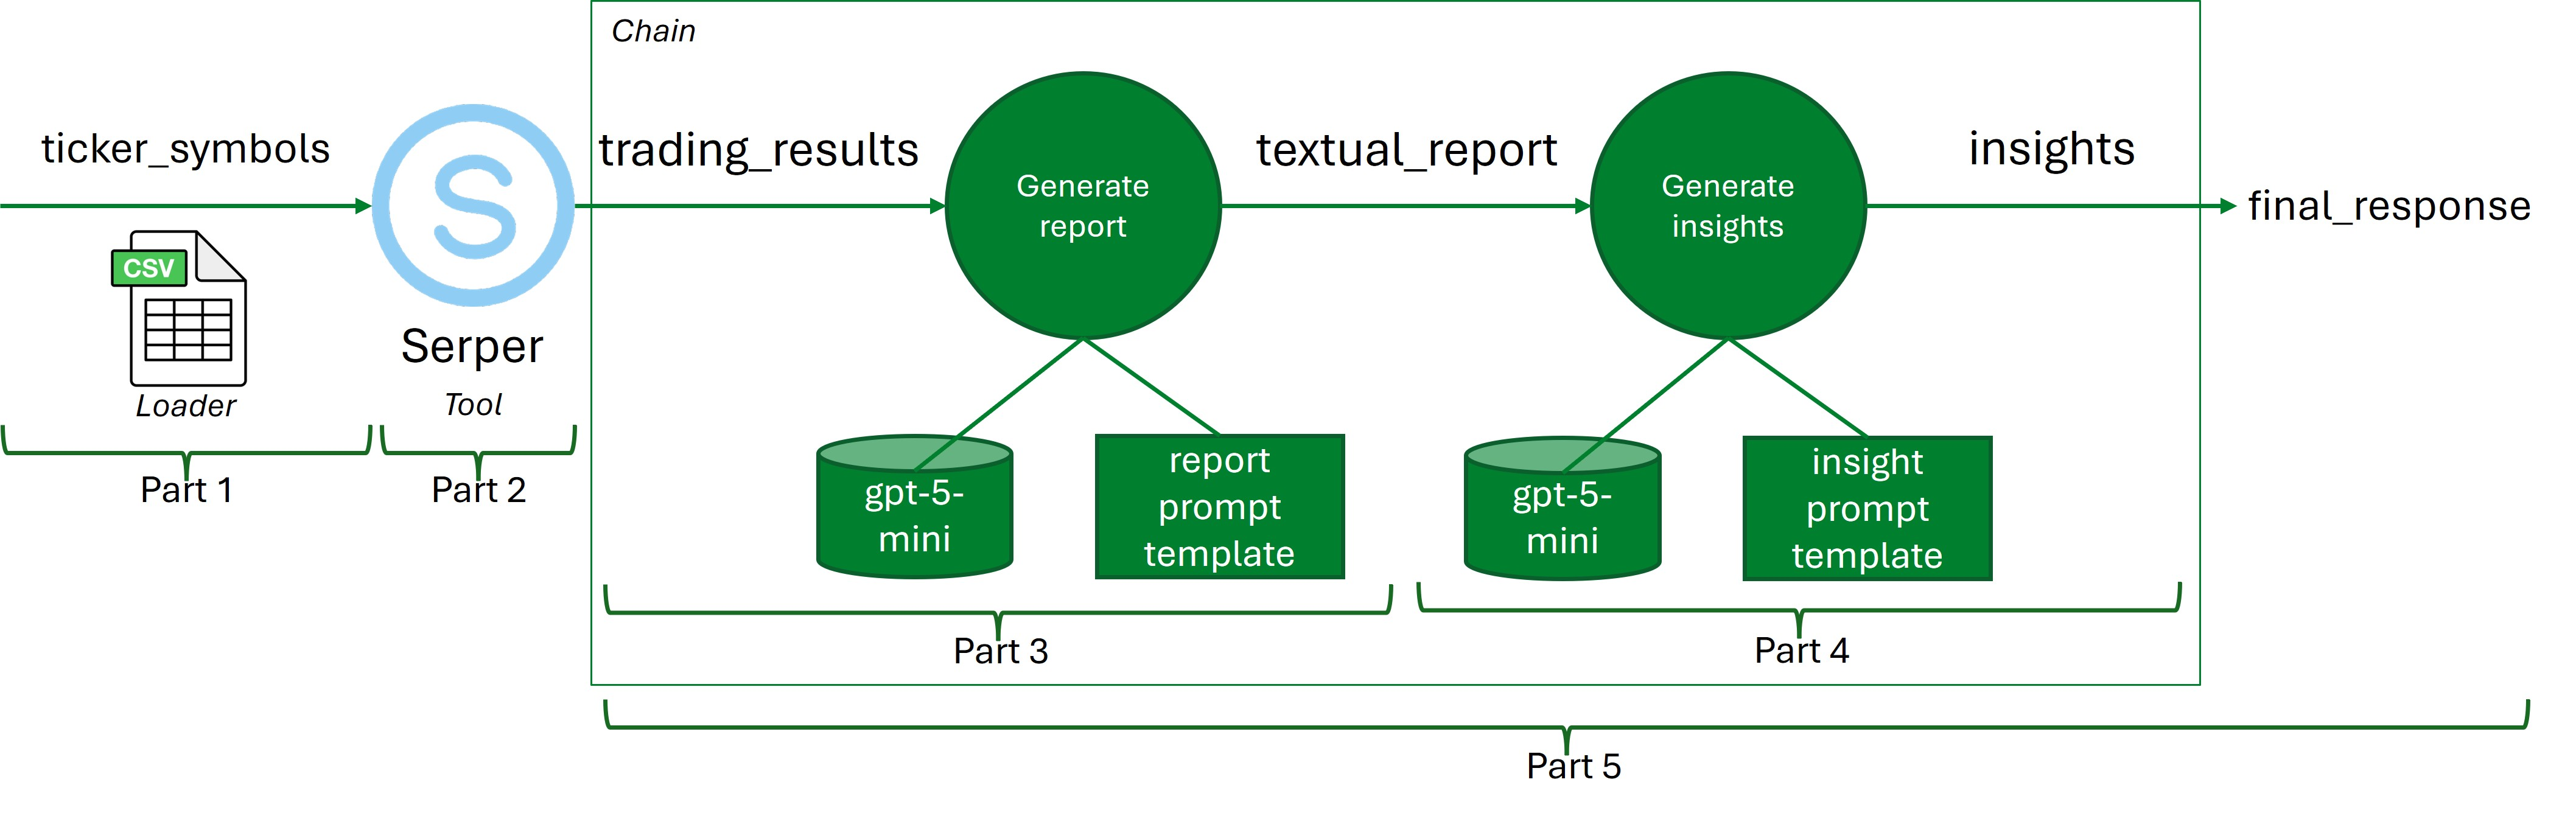

### Part 1: Load from a CSV file the ticker symbols of the companies you invest in

In the first step, you load a list of ticker symbols of companies in the stock market. The list is provided in a CSV file `ticker_symbols.csv`. You can find the CSV File in Canvas. Store the file locally on your computer and upload it using the upload option at the top of the file-explorer pane to upload any file(s) from your local file system to Colab in the present working directory.

Use `CSVLoader` to load the CSV file into a variable called `ticker_document`.

In [ ]:
# Load and split the CSV content
## YOUR CODE (START)
loader = CSVLoader(file_path="/content/ticker_symbols.csv")
ticker_document = loader.load()
## YOUR CODE (END)

Now that the CSV file is loaded into `ticker_document`, you can ask an LLM to read `ticker_document` and return a list of the ticker symbols in it.

To do so, use `PrompTemplate` to define a prompt template called `ticker_prompt_template`.

The prompt template should take an input variable `document`.

The template should ask to provide a list with the ticker symbols extracted from the document in input.

In [ ]:
# Define the prompt template
## YOUR CODE (START)
ticker_prompt_template = PromptTemplate(
    input_variables = ["document"],
    template = "Give me a list with the ticker symbols extracted from the attached document: {document}. The response should just be a list of strings in double quotes"
)
## YOUR CODE (END)

Next, define a `ticker_prompt` by using `format` to format the prompt template so that the input variable `document` is bound to `ticker_document`.

In [ ]:
# Format the ticker prompt template
## YOUR CODE (START)
ticker_prompt = ticker_prompt_template.format(document=ticker_document)
## YOUR CODE (END)

Now invoke the model (`llm`) passing the `ticker_prompt` as parameter; the output of the invocation should be assigned to variable `ticker_symbols_from_llm`. Note that this output is an object of type string representing a list.

In [ ]:
#Run the chain
## YOUR CODE (START)
ticker_symbols_from_llm = llm.invoke(ticker_prompt)
## YOUR CODE (END)

Lastly, convert the string `ticker_symbols_from_llm` into a list called `ticker_symbols`.

To do so, you can use function `ast.literal_eval`, passing `ticket_symbols_from_llm.content` as parameter.

Assign the result of the invocation to variable `ticker_symbols`, and print it.

In [ ]:
#Run the chain
## YOUR CODE (START)
ticker_symbols = ast.literal_eval(ticker_symbols_from_llm.content)
print(ticker_symbols)
## YOUR CODE (END)

Now you have a list `ticker_symbols` that originates from a CSV file and that you can use to get trading results and actionable insights, like in exercise 2.

The continuation now is the same as in exercise 2: once you execute the code in the above cells of Exercise 5, you can continue by re-executing the code in the cells of Parts 2--5 above.